# Group 70: Project Proposal
## Predicting Cancer Mortality Rates Through Varying Demographic Data

### Introduction
Cancer is one of the leading causes of death in the developed world. Therefore, it is crucial that we investigate the links between cancer mortality rates and demographic data. Using a dataset imported from data.world that aggregates data from the American Community Survey, clinicaltrails.gov (a public clinical trial database), and the National Cancer Institute, we hope to predict the cancer mortality rate of a county using demographic data. Our question is the following: if given the median age and income of a county in the United States, what will be the cancer mortality rate of that county? Our claim is that a county with a higher median age and lower median income will lead to higher cancer mortality rates. We chose median age and median income as our variables because prior research (cited below) demonstrate a significant relationship between these variables and cancer mortality.

### Loading libraries

In [1]:
library(tidyverse) # to perform operations on the data set
library(repr) # to set graph plot size and performing some operations on data set
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading data from URL

In [8]:
# Reading the training data set from the Web into R
url <- "https://raw.githubusercontent.com/mimilht/dsci100-proj-group70/main/cancer_reg.csv"
cancer <- read_csv(url)

Rows: 3047 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): binnedInc, Geography
dbl (32): avgAnnCount, avgDeathsPerYear, TARGET_deathRate, incidenceRate, me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and Wrangling Data into Tidydata Format

In [3]:
cancer_data <- cancer_data |> 
    select(medIncome, MedianAge, TARGET_deathRate) |> # selecting only relevant columns
    filter(na.rm = TRUE) |> # removing observations with N/A values
    filter(MedianAge <= 100) |> # removing observations with erroneous median age
    rename(MedianIncome = medIncome,
           DeathsPerCapita = TARGET_deathRate) # renaming columns to consistent format
head(cancer_data) # display first 6 rows of data

MedianIncome,MedianAge,DeathsPerCapita
<dbl>,<dbl>,<dbl>
61898,39.3,164.9
48127,33.0,161.3
49348,45.0,174.7
44243,42.8,194.8
49955,48.3,144.4
52313,45.4,176.0


### Splitting Dataframe into Training/Testing Data

In [4]:
cancer_split <- initial_split(cancer_data, prop = 0.75, strata = DeathsPerCapita) 
# splitting data into 25% testing, 75% training
cancer_training <- training(cancer_split)
cancer_test <- testing(cancer_split)

### Summarizing Data

In [5]:
cancer_count <- colSums(!is.na(cancer_training)) # reports number of observations
cancer_count

cancer_avg <- map_df(cancer_training, mean) # reports mean of each variable
cancer_avg

MedianIncome       MedianAge DeathsPerCapita 
           2261            2261            2261

MedianIncome,MedianAge,DeathsPerCapita
<dbl>,<dbl>,<dbl>
47028.29,40.76749,178.4206


### Visualizing Data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



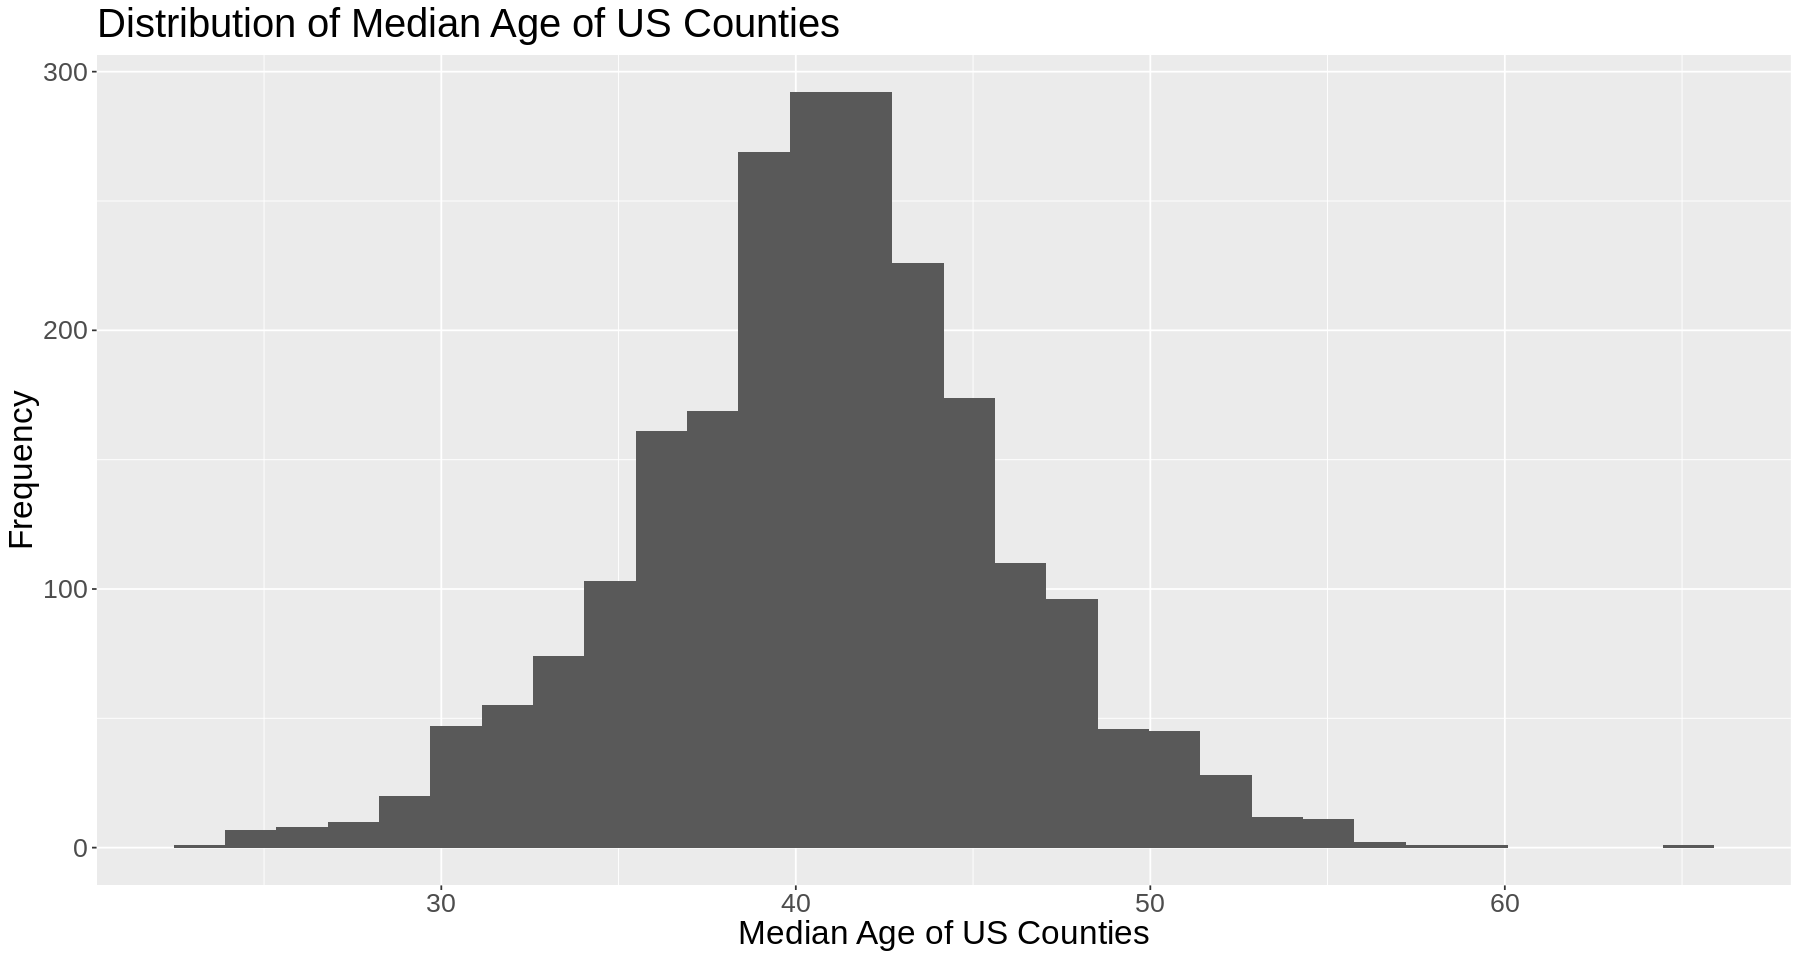

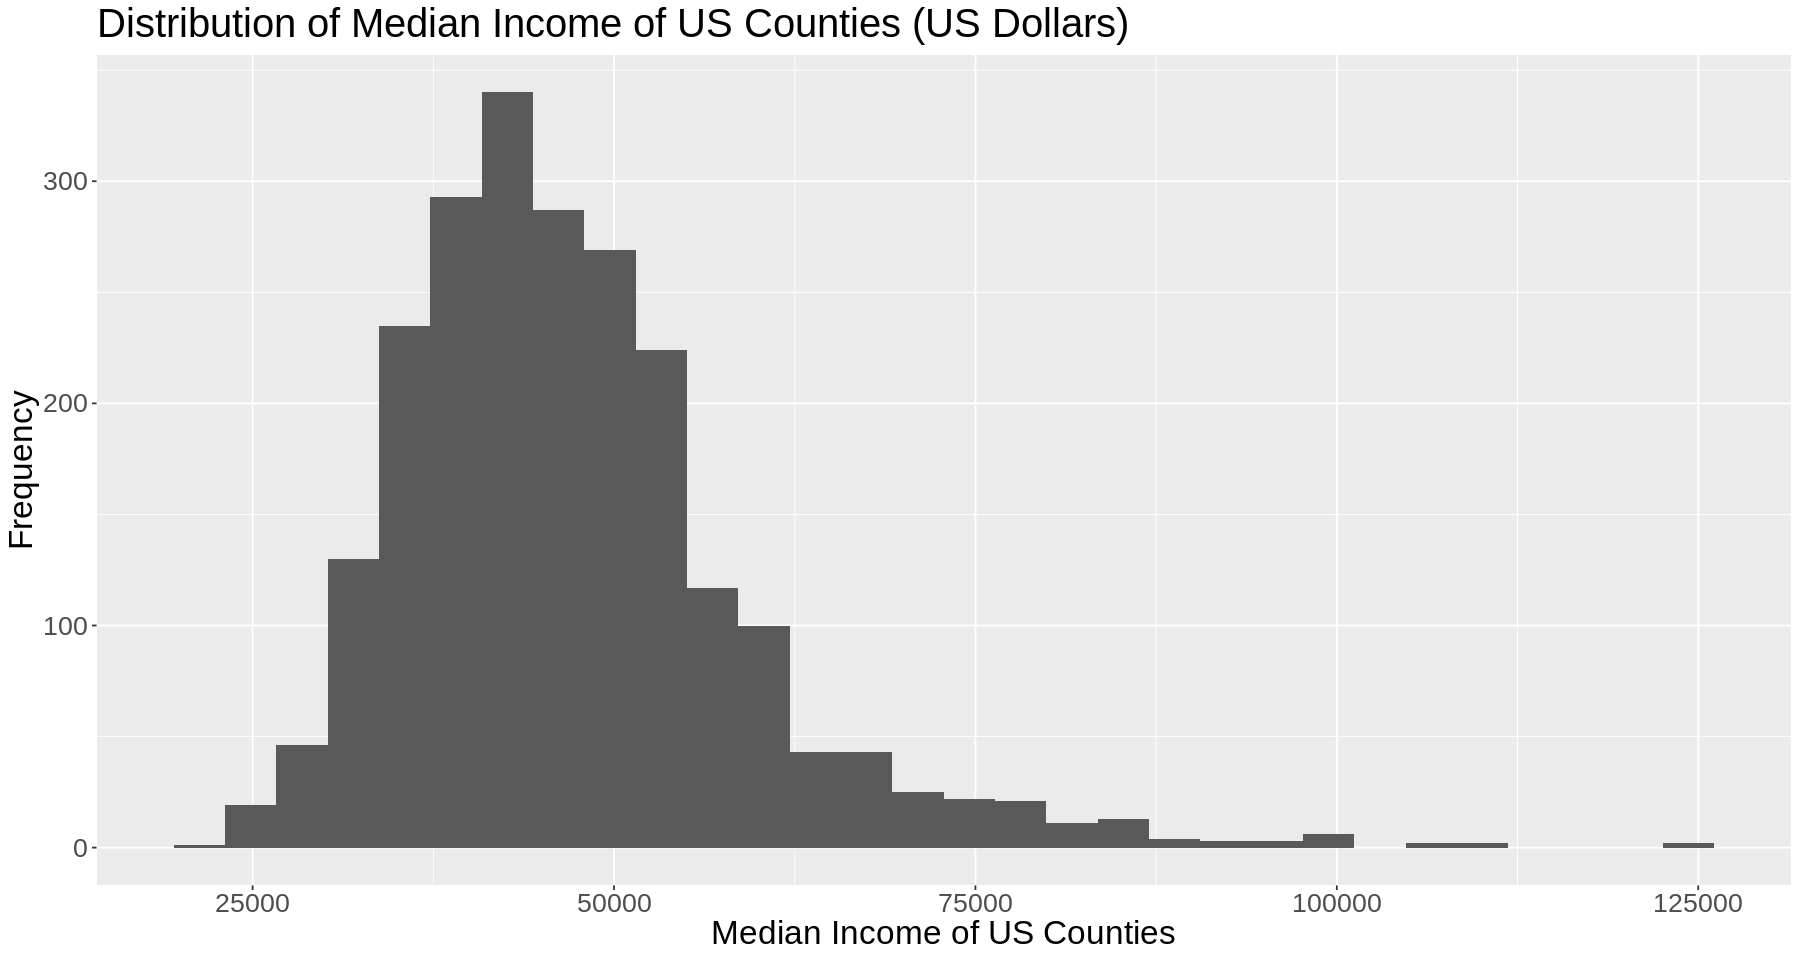

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8) # adjusts graph size

cancer_plot_age <- ggplot(cancer_training, aes(x = MedianAge)) +
    geom_histogram() + # using histogram to show distribution
    labs(x = "Median Age of US Counties", y = "Frequency") + # label axes
    ggtitle("Distribution of Median Age of US Counties") + # create graph title
    theme(text = element_text(size = 20)) # adjust text size
cancer_plot_income <- ggplot(cancer_training, aes(x = MedianIncome)) +
    geom_histogram() +
    labs(x = "Median Income of US Counties", y = "Frequency") +
    ggtitle("Distribution of Median Income of US Counties (US Dollars)") +
    theme(text = element_text(size = 20))
cancer_plot_age
cancer_plot_income

In [ ]:
### Data Analysis

In [9]:
cancer

avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,⋯,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1397,469,164.9,489.8,61898,260131,11.2,499.74820,"(61494.5, 125635]",39.3,⋯,NA,41.6,32.9,14.0,81.78053,2.59472833,4.82185710,1.84347853,52.85608,6.1188310
173,70,161.3,411.6,48127,43269,18.6,23.11123,"(48021.6, 51046.4]",33.0,⋯,53.8,43.6,31.1,15.3,89.22851,0.96910246,2.24623259,3.74135153,45.37250,4.3330956
102,50,174.7,349.7,49348,21026,14.6,47.56016,"(48021.6, 51046.4]",45.0,⋯,43.5,34.9,42.1,21.1,90.92219,0.73967339,0.46589818,2.74735831,54.44487,3.7294878
427,202,194.8,430.4,44243,75882,17.1,342.63725,"(42724.4, 45201]",42.8,⋯,40.3,35.0,45.3,25.0,91.74469,0.78262597,1.16135867,1.36264318,51.02151,4.6038408
57,26,144.4,350.1,49955,10321,12.5,0.00000,"(48021.6, 51046.4]",48.3,⋯,43.9,35.1,44.0,22.7,94.10402,0.27019203,0.66583036,0.49213548,54.02746,6.7966574
428,152,176.0,505.4,52313,61023,15.6,180.25990,"(51046.4, 54545.6]",45.4,⋯,38.8,32.6,43.2,20.2,84.88263,1.65320524,1.53805662,3.31463539,51.22036,4.9644760
250,97,175.9,461.8,37782,41516,23.2,0.00000,"(37413.8, 40362.7]",42.6,⋯,35.0,28.3,46.4,28.7,75.10646,0.61695539,0.86615697,8.35672118,51.01390,4.2043173
146,71,183.6,404.0,40189,20848,17.8,0.00000,"(37413.8, 40362.7]",51.7,⋯,33.1,25.9,50.9,24.1,89.40664,0.30515863,1.88907726,2.28626786,48.96703,5.8891790
88,36,190.5,459.4,42579,13088,22.3,0.00000,"(40362.7, 42724.4]",49.3,⋯,37.8,29.9,48.1,26.6,91.78748,0.18507094,0.20820481,0.61690315,53.44700,5.5875831


In [16]:
cancer_filter <- cancer |> filter(na.rm = TRUE)
cancer_filter
colSums(!is.na(cancer_filter))

avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,⋯,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1397,469,164.9,489.8,61898,260131,11.2,499.74820,"(61494.5, 125635]",39.3,⋯,NA,41.6,32.9,14.0,81.78053,2.59472833,4.82185710,1.84347853,52.85608,6.1188310
173,70,161.3,411.6,48127,43269,18.6,23.11123,"(48021.6, 51046.4]",33.0,⋯,53.8,43.6,31.1,15.3,89.22851,0.96910246,2.24623259,3.74135153,45.37250,4.3330956
102,50,174.7,349.7,49348,21026,14.6,47.56016,"(48021.6, 51046.4]",45.0,⋯,43.5,34.9,42.1,21.1,90.92219,0.73967339,0.46589818,2.74735831,54.44487,3.7294878
427,202,194.8,430.4,44243,75882,17.1,342.63725,"(42724.4, 45201]",42.8,⋯,40.3,35.0,45.3,25.0,91.74469,0.78262597,1.16135867,1.36264318,51.02151,4.6038408
57,26,144.4,350.1,49955,10321,12.5,0.00000,"(48021.6, 51046.4]",48.3,⋯,43.9,35.1,44.0,22.7,94.10402,0.27019203,0.66583036,0.49213548,54.02746,6.7966574
428,152,176.0,505.4,52313,61023,15.6,180.25990,"(51046.4, 54545.6]",45.4,⋯,38.8,32.6,43.2,20.2,84.88263,1.65320524,1.53805662,3.31463539,51.22036,4.9644760
250,97,175.9,461.8,37782,41516,23.2,0.00000,"(37413.8, 40362.7]",42.6,⋯,35.0,28.3,46.4,28.7,75.10646,0.61695539,0.86615697,8.35672118,51.01390,4.2043173
146,71,183.6,404.0,40189,20848,17.8,0.00000,"(37413.8, 40362.7]",51.7,⋯,33.1,25.9,50.9,24.1,89.40664,0.30515863,1.88907726,2.28626786,48.96703,5.8891790
88,36,190.5,459.4,42579,13088,22.3,0.00000,"(40362.7, 42724.4]",49.3,⋯,37.8,29.9,48.1,26.6,91.78748,0.18507094,0.20820481,0.61690315,53.44700,5.5875831


avgAnnCount        avgDeathsPerYear        TARGET_deathRate 
                   3047                    3047                    3047 
          incidenceRate               medIncome              popEst2015 
                   3047                    3047                    3047 
         povertyPercent             studyPerCap               binnedInc 
                   3047                    3047                    3047 
              MedianAge           MedianAgeMale         MedianAgeFemale 
                   3047                    3047                    3047 
              Geography        AvgHouseholdSize          PercentMarried 
                   3047                    3047                    3047 
           PctNoHS18_24              PctHS18_24         PctSomeCol18_24 
                   3047                    3047                     762 
        PctBachDeg18_24            PctHS25_Over       PctBachDeg25_Over 
                   3047                    3047                    3047 
     PctEmployed16_Over    PctUnemployed16_Over      PctPrivateCoverage 
                   2895                    3047                    3047 
PctPrivateCoverageAlone      PctEmpPrivCoverage       PctPublicCoverage 
                   2438                    3047                    3047 
 PctPublicCoverageAlone                PctWhite                PctBlack 
                   3047                    3047                    3047 
               PctAsian            PctOtherRace    PctMarriedHouseholds 
                   3047                    3047                    3047 
              BirthRate 
                   3047

In [18]:
# get rid PctSomeCol18_24, PctEmployed16_Over, PctPrivateCoverageAlone because they don't have 3047 observations
cancer_filter <- cancer_filter |> select(-PctSomeCol18_24, PctEmployed16_Over,PctPrivateCoverageAlone)
cancer_filter

ERROR: [1m[33mError[39m in [1m[1m`select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `PctSomeCol18_24` doesn't exist.


In [ ]:
cancer_subset <- cancer_training |> 
  select(Class, 
         Smoothness, 
         Concavity, 
         Perimeter, 
         Irrelevant1, 
         Irrelevant2, 
         Irrelevant3)

names <- colnames(cancer_subset |> select(-Class))

cancer_subset

### Method

To prepare our data for analysis, we started out with downloading the dataset from the web and publishing the data on our group GitHub. We then pulled the dataset and read it on Jupyter using a URL.

Then we decided to select and filter out the columns that are required for our analysis and decided to leave the rest out. We agreed to select the Median_Age and Median_Income columns as predictors in our research. We filtered our data to only contain observations of counties with median ages less than 100 to sieve out faulty and inaccurate data. We also removed cells that have missing data (NA). We also changed the column names to make it more human readable and easier to interpret.

The dataset required minimal cleaning as the data was in a relatively tidy format, and there wasn’t any metadata attached in the file nor was there any mismatch of rows and columns.

We are using median income/age to predict cancer mortality (average death per year). We hope to analyze our data using a regression model, specifically linear regression. However, if linear regression proves to be inappropriate for predicting the mortality rate, we will consider exploring the use of a KNN regression model.

### Discussion

We expect to find a positive correlation between the median age of counties and the cancer mortality rate (deaths per capita). We also expect that mortality rate increases with a decrease in median income.

We hope that our findings can affirm a greater need for healthcare access and support in geographic areas with lower-income and elderly populations. The results of this study could lead to other research questions investigating the trends between demographic data and other illnesses, such as heart disease, diabetes, and obesity. Our findings could also help in making decisions about distribution of healthcare infrastructure and facilities according to more vulnerable demographics.

### Sources cited
1) Siegel, R. L., Miller, K. D., Wagle, N. S., & Jemal, A. (2023). Cancer statistics, 2023. CA: A Cancer Journal for Clinicians, 73(1), 17–48. https://doi.org/10.3322/caac.21763 
2) Vaccarella, S., Georges, D., Bray, F., Ginsburg, O., Charvat, H., Martikainen, P., Brønnum-Hansen, H., Deboosere, P., Bopp, M., Leinsalu, M., Artnik, B., Lorenzoni, V., De Vries, E., Marmot, M., Vineis, P., Mackenbach, J., & Nusselder, W. (2023). Socioeconomic inequalities in cancer mortality between and within countries in Europe: A population-based study. The Lancet Regional Health - Europe, 25, 100551. https://doi.org/10.1016/j.lanepe.2022.100551 